In [ ]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from xNNoost import XNNClassifier
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

2025-04-27 12:07:21.456573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [5]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [6]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [7]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [ ]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")

import keras



from sklearn.metrics import balanced_accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
"## import batch normalization"
from keras.layers import BatchNormalization

def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
                     input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
X_test_reshaped = X.reshape((-1, 20, 20, 1))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape the input data to match the expected input shape of the CNN
train_X = train_X.reshape((-1, 20, 20, 1))
test_X = test_X.reshape((-1, 20, 20, 1))

# Train the model
model = create_cnn_model()
model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate using balanced accuracy score
print("Balanced accuracy score:", balanced_accuracy_score(test_y, y_pred_classes).round(4))



Class names: ['chainsaw' 'fire' 'fireworks' 'gun']
Shape of the feature matrix : (274, 400)
Number of labels : 274
Class 'chainsaw': 80 samples
Class 'fire': 79 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples
Epoch 1/50


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3701 - loss: 2.8397 - val_accuracy: 0.5227 - val_loss: 3.4809
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5560 - loss: 1.7177 - val_accuracy: 0.5455 - val_loss: 2.2276
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6078 - loss: 1.2502 - val_accuracy: 0.5227 - val_loss: 2.5646
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6206 - loss: 1.0498 - val_accuracy: 0.5909 - val_loss: 2.1532
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6434 - loss: 0.8298 - val_accuracy: 0.5909 - val_loss: 1.7835
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7246 - loss: 0.7125 - val_accuracy: 0.5909 - val_loss: 1.6896
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7081 - loss: 0.7086 - val_accuracy: 0.6364 - val_loss: 1.2402
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7304 - loss: 0.6860 - val_accuracy: 0.6591 - val_loss: 1.0814
Epoch 9/50


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


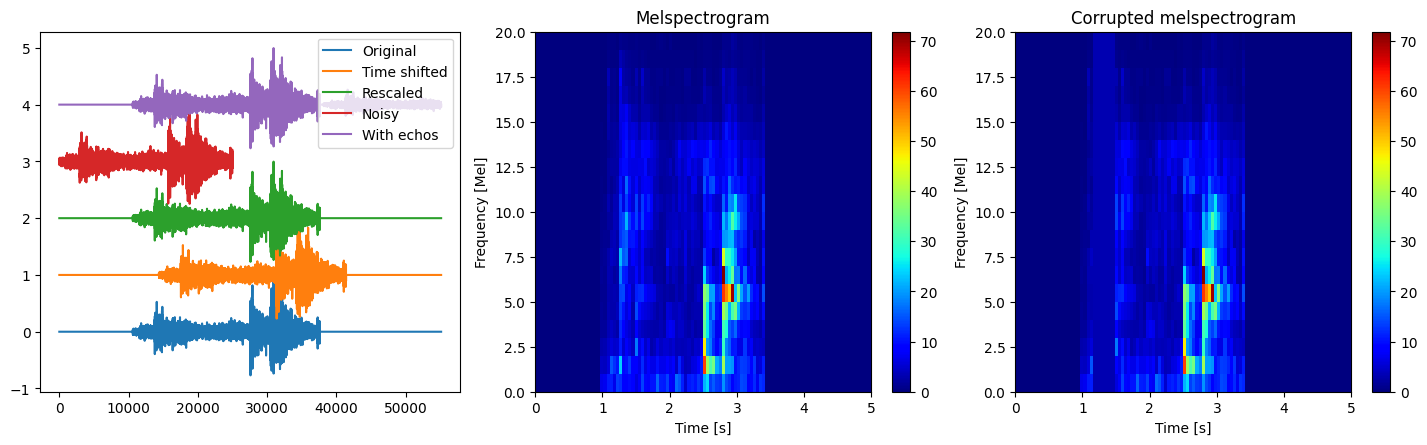

In [9]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
# audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
# ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [ ]:
from tqdm import tqdm

### TO RUN
# Initialize the feature matrix and labels for multiple shift_pct values
shift_pct_values = np.arange(0, 0.96, 0.96/5).tolist()  # List of shift_pct values
X_aug_list = []
y_aug_list = []

naudio_sum = sum(naudio.values())
for shift_pct in tqdm(shift_pct_values, desc="Processing shift_pct values"):
    # Create a Feature_vector_DS for the current shift_pct
    myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
    myds_shifted.mod_data_aug(["noise", "echo","background_noise"])
    
    # Initialize feature matrix and labels for the current shift_pct
    X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
    y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)
    
    # Generate feature vectors and labels
    for s in range(myds_shifted.data_aug_factor):
        offset = 0
        for class_idx, classname in enumerate(classnames):
            num_samples = naudio[classname]  # Number of samples for the current class
            for idx in range(num_samples):
                featvec = myds_shifted[classname, idx]
                X_aug_shifted[s * naudio_sum + offset + idx, :] = featvec
                y_aug_shifted[s * naudio_sum + offset + idx] = classname
            offset += num_samples  # Update the offset for the next class
    
    # Append the current shift_pct data to the lists
    print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
    X_aug_list.append(X_aug_shifted)
    y_aug_list.append(y_aug_shifted)

# Concatenate all feature matrices and labels
X_aug = np.vstack(X_aug_list)
y_aug = np.concatenate(y_aug_list)

# Save the feature matrices
np.save(fm_dir + "feature_matrix_2D_NN.npy", X_aug)
np.save(fm_dir + "labels_2D_test_NN.npy", y_aug)

# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (6850, 400)
Number of labels : 6850


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import keras
import pandas as pd

X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                                          test_size=0.3, 
                                                                          random_state=40,stratify=y_aug)
X_train_normalized = X_train_normalized.reshape(-1, 20, 20, 1)

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# print(y_train_encoded)
# print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Number of classes: {len(np.unique(y_train_encoded))}")
def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
                     input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_cnn_model()
# Fit the model on 100 epochs
model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
balanced accuracy score: 0.9817


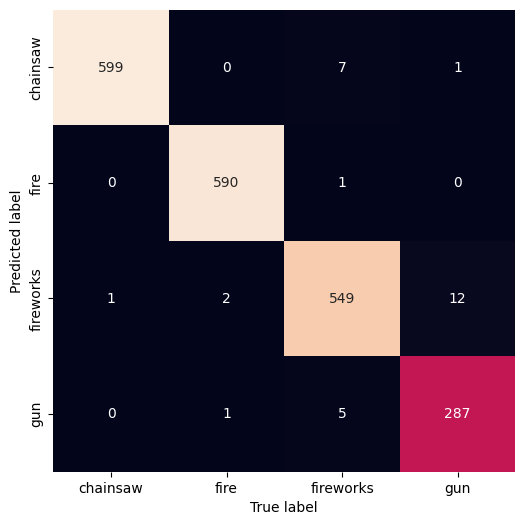

In [24]:
# test_accuracy = 0
# while test_accuracy < 0.96:
#     print("Test accuracy below 0.96, recreating and retraining the model...")
#     model = create_cnn_model()
#     model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)
#     X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
#     test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
#     print(f"Test accuracy of the current iteration: {test_accuracy:.4f}")
# print(f"Test accuracy: {test_accuracy:.4f}")
# print("Saving the best CNN model...")
# model.save("CNN_LAST.keras")
from sklearn.metrics import balanced_accuracy_score
model = keras.models.load_model("data/models/CNN_LAST.keras")
X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))


y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))

show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import pandas as pd

# Define the CNN model for Grid Search
def create_cnn_model(optimizer='adam', learning_rate=0.001, dropout_conv=0.25, dropout_dense=0.5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    # Optimizer choice
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=create_cnn_model,
#     epochs=100,
#     batch_size=32,
#     verbose=0
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'model__optimizer': ['adam', 'sgd', 'rmsprop'],
#     'model__learning_rate': [0.001, 0.005, 0.01],
#     'model__dropout_conv': [0.25, 0.5],
#     'model__dropout_dense': [0.5, 0.75],
# }

# # Define a custom scoring function using balanced_accuracy_score
# scorer = make_scorer(balanced_accuracy_score)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train_normalized, y_train_encoded)

# # Save results to a CSV file
# results_df = pd.DataFrame(grid_result.cv_results_)
# results_df.to_csv("grid_search_results.csv", index=False)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Balanced Accuracy Score: {grid_result.best_score_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


2025-04-27 12:07:30.107458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.107746: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.110827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.110977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.120572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 12:07:30.121842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

Best Parameters: {'model__dropout_conv': 0.25, 'model__dropout_dense': 0.5, 'model__learning_rate': 0.01, 'model__optimizer': 'sgd'}
Best Balanced Accuracy Score: 0.9511842983263968


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder_aug = LabelEncoder()
y_aug_encoded = label_encoder_aug.fit_transform(y_aug)

# Ensure the original dataset labels are also encoded
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Function to train and evaluate the model
def train_and_evaluate(X, y, num_runs=10):
    scores = []
    for _ in range(num_runs):
        # Split the dataset
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Reshape the input data to match the expected input shape of the CNN
        train_X = train_X.reshape((-1, 20, 20, 1))
        test_X = test_X.reshape((-1, 20, 20, 1))
        
        # Train the model
        model = create_cnn_model()
        model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
        
        # Make predictions
        y_pred = model.predict(test_X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Evaluate using balanced accuracy score
        score = balanced_accuracy_score(test_y, y_pred_classes)
        scores.append(score)
    return scores

# Run the process for the original dataset
print("Evaluating on the original dataset...")
original_scores = train_and_evaluate(X, y, num_runs=10)


Evaluating on the original dataset...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Evaluating on the augmented dataset...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-27 17:22:26.743253: W tensorflow/core/framework/op_kernel.cc:1833] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "/home/ulysse/.rye/py/cpython@3.9.18/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/ulysse/.rye/py/cpython@3.9.18/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/ulysse/.rye/py/cpython@3.9.18/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/ulysse/.rye/py/cpython@3.9.18/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/ulysse/.rye/py/cpython@3.9.18/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_4884/2572655625.py", line 42, in <module>

  File "/tmp/ipykernel_4884/2572655625.py", line 25, in train_and_evaluate

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/losses/loss.py", line 63, in __call__

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/tree/tree_api.py", line 192, in map_structure

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/tree/optree_impl.py", line 108, in map_structure

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/optree/ops.py", line 766, in tree_map

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/losses/loss.py", line 64, in <lambda>

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/ops/core.py", line 958, in convert_to_tensor

  File "/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/core.py", line 147, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/sparse_categorical_crossentropy/Cast}}]] [Op:__inference_multi_step_on_iterator_593526]

/tmp/ipykernel_4884/3011958415.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


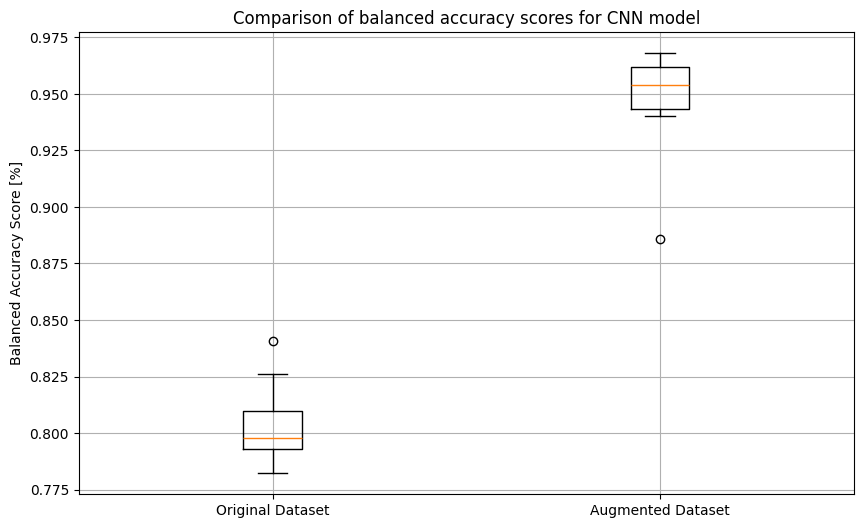

Original Dataset: Mean = 0.8035, Std = 0.0173
Augmented Dataset: Mean = 0.9480, Std = 0.0227


In [41]:
from matplotlib.backends.backend_pdf import PdfPages


# augmented_scores = []
# model = keras.models.load_model("data/models/CNN_LAST.keras")
# for i in range(10):
#     # Split the dataset
#     train_X, test_X, train_y, test_y = train_test_split(X_aug, y_aug_encoded, test_size=0.2, random_state=None)
    
#     # Reshape the input data to match the expected input shape of the CNN
#     train_X = train_X.reshape((-1, 20, 20, 1))
#     test_X = test_X.reshape((-1, 20, 20, 1))
    
#     # Train the model
#     model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
    
#     # Make predictions
#     y_pred = model.predict(test_X)
#     y_pred_classes = np.argmax(y_pred, axis=1)
    
#     # Evaluate using balanced accuracy score
#     score = balanced_accuracy_score(test_y, y_pred_classes)
#     augmented_scores.append(score)
augmented_scores = [94.04,96.8,95.2,95.6,96.4,96.8,95.6,94.2,94.8,88.6]
for i in range(len(augmented_scores)):
    augmented_scores[i] = augmented_scores[i]/100

# Create box plots to compare the results
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of balanced accuracy scores for CNN model")
plt.ylabel("Balanced Accuracy Score [%]")
plt.grid(True)
with PdfPages('balanced_accuracy_scores_comparison.pdf') as pdf:
    pdf.savefig()  # saves the current figure
plt.show()

# Save the plot to a PDF file
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")